In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

path = "drive/MyDrive/HealthML/final_project_files/"
train = pd.read_csv(path + "Processed_Dataset/train_processed.csv")
val = pd.read_csv(path + "Processed_Dataset/val_processed.csv")
test = pd.read_csv(path + "Processed_Dataset/test_processed.csv")

# Model Preparation

Load the ClinicalBERT model with a classification head from the Hugging Face transformers library: https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT?text=Paris+is+the+%5BMASK%5D+of+France.

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, logging
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Suppress info messages from transformers (optional, not necessary)
logging.set_verbosity_warning()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Load Bio_ClinicalBERT with Classification Head
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=1,
    ignore_mismatched_sizes=True  # This will suppress the warnings about mismatch sizes
)

# Class for handling tokenization
class NotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Ensure all sequences are padded to the same length
            truncation=True,  # Ensure that sequences longer than model max are truncated
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

def create_data_loader(df, tokenizer, batch_size, max_len=512):
    ds = NotesDataset(
        texts=df.TEXT.to_numpy(),
        labels=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

batch_size = 64
train_data_loader = create_data_loader(train, tokenizer, batch_size)
val_data_loader = create_data_loader(val, tokenizer, batch_size)
test_data_loader = create_data_loader(test, tokenizer, batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1.3514012837218262e-05)
total_steps = len(train_data_loader) * 10  # 10 is the number of epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    total_batches = len(data_loader)
    for step, d in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training", position=0, leave=True):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        model.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).int().squeeze()
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

# Hyperparameter Tuning

---



In [ ]:
def evaluate_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

In [ ]:
small_train = train.sample(frac=0.1, random_state=42)
small_val = val.sample(frac=0.1, random_state=42)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import AdamW, get_scheduler

def objective(trial):
    # Define hyperparameter search space
    learning_rate = trial.suggest_float("lr", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Create dataloaders with the suggested batch size
    train_loader = create_data_loader(small_train, tokenizer, batch_size)
    val_loader = create_data_loader(small_val, tokenizer, batch_size)

    # Initialize model and optimizer
    model = BertForSequenceClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",
        num_labels=1,   ### SELF - changed to 1
        ignore_mismatched_sizes=True
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,  # You can adjust this if needed
        num_training_steps=len(train_loader) * 10  # Assuming 10 epochs
    )

    # Train for 1 epoch to validate performance
    train_acc, train_loss = train_epoch(
        model, train_loader, optimizer, device, scheduler, len(small_train)
    )
    val_acc, val_loss = evaluate_model(
        model, val_loader, device, len(small_val)
    )

    return val_loss  # Minimize validation loss

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-12-07 20:10:12,897] A new study created in memory with name: no-name-63cccfdc-fce8-47ff-beec-adf636388cbc
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.1843


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1385



[I 2024-12-07 20:14:15,806] Trial 0 finished with value: 0.17209692165422974 and parameters: {'lr': 3.84328421973801e-05, 'batch_size': 32}. Best is trial 0 with value: 0.17209692165422974.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2151



[I 2024-12-07 20:18:12,078] Trial 1 finished with value: 0.20160158162706354 and parameters: {'lr': 1.5958357107423606e-06, 'batch_size': 64}. Best is trial 0 with value: 0.17209692165422974.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2439


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1625



[I 2024-12-07 20:22:14,726] Trial 2 finished with value: 0.16709637863749868 and parameters: {'lr': 4.92357450771844e-06, 'batch_size': 32}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2046



[I 2024-12-07 20:26:10,969] Trial 3 finished with value: 0.1961779272958134 and parameters: {'lr': 2.965002315392713e-06, 'batch_size': 64}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1966



[I 2024-12-07 20:30:07,197] Trial 4 finished with value: 0.19432805729716013 and parameters: {'lr': 2.4214813423638387e-06, 'batch_size': 64}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2795


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1559



[I 2024-12-07 20:34:09,937] Trial 5 finished with value: 0.17637190197625857 and parameters: {'lr': 3.3757787861212712e-06, 'batch_size': 32}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1490



[I 2024-12-07 20:38:06,226] Trial 6 finished with value: 0.1665813819913382 and parameters: {'lr': 1.3514012837218262e-05, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2052



[I 2024-12-07 20:42:02,438] Trial 7 finished with value: 0.197393065590537 and parameters: {'lr': 1.7322041230450678e-06, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2012



[I 2024-12-07 20:45:58,690] Trial 8 finished with value: 0.1876595810558019 and parameters: {'lr': 3.536492205718577e-06, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:37,  3.24it/s]

Batch 200/712, Loss: 0.3296


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.1728


Training:  84%|████████▍ | 600/712 [03:05<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1136


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.1907



[I 2024-12-07 20:50:14,478] Trial 9 finished with value: 0.17572172968320443 and parameters: {'lr': 2.695536831520096e-06, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:37,  3.24it/s]

Batch 200/712, Loss: 0.2219


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.1431


Training:  84%|████████▍ | 600/712 [03:04<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1208


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.1989



[I 2024-12-07 20:54:30,199] Trial 10 finished with value: 0.16866206592342384 and parameters: {'lr': 1.4212587157539647e-05, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2044


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1291



[I 2024-12-07 20:58:32,896] Trial 11 finished with value: 0.16810587207587918 and parameters: {'lr': 1.0919574505607737e-05, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2034


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1474



[I 2024-12-07 21:02:35,557] Trial 12 finished with value: 0.16859008509958728 and parameters: {'lr': 6.57152752651737e-06, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.1823


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1438



[I 2024-12-07 21:06:38,277] Trial 13 finished with value: 0.17415158900568325 and parameters: {'lr': 2.64772789208653e-05, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:38,  3.24it/s]

Batch 200/712, Loss: 0.3415


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.1687


Training:  84%|████████▍ | 600/712 [03:05<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1215


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.2148



[I 2024-12-07 21:10:54,076] Trial 14 finished with value: 0.1688195075472476 and parameters: {'lr': 6.9713213599860875e-06, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1436



[I 2024-12-07 21:14:50,347] Trial 15 finished with value: 0.17196995697999268 and parameters: {'lr': 1.5993728437505313e-05, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2967


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.2153



[I 2024-12-07 21:18:53,068] Trial 16 finished with value: 0.20453939712449407 and parameters: {'lr': 1.0187645111642552e-06, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1832



[I 2024-12-07 21:22:49,413] Trial 17 finished with value: 0.18644848265004962 and parameters: {'lr': 5.3612688623031435e-06, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2531


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1403



[I 2024-12-07 21:26:52,007] Trial 18 finished with value: 0.16760986771308975 and parameters: {'lr': 1.08434805933606e-05, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:38,  3.24it/s]

Batch 200/712, Loss: 0.2806


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.0960


Training:  84%|████████▍ | 600/712 [03:05<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1513


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.2162



[I 2024-12-07 21:31:07,814] Trial 19 finished with value: 0.17131565588355904 and parameters: {'lr': 2.032275917346701e-05, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.


Best hyperparameters: {'lr': 1.3514012837218262e-05, 'batch_size': 64}


In [ ]:
# best_params = {'lr': 1.3514012837218262e-05, 'batch_size': 64}

# Training

In [ ]:
import os

# Define a directory to save checkpoints
checkpoint_dir = "drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints"  # Adjust the path
os.makedirs(checkpoint_dir, exist_ok=True) # Create directory if it doesn't exist

In [ ]:
for epoch in tqdm(range(10)):
    print(f'Epoch {epoch + 1}')
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(train)  # Make sure 'train' contains the correct number of samples
    )
    print(f'Train loss {train_loss:.4f}, Accuracy {train_acc:.4f}')

    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


Training: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]


Train loss 0.2391, Accuracy 0.3960


 10%|█         | 1/10 [01:03<09:27, 63.03s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_1.pth
Epoch 2


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2317, Accuracy 0.3430


 20%|██        | 2/10 [02:04<08:19, 62.39s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_2.pth
Epoch 3


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2299, Accuracy 0.3350


 30%|███       | 3/10 [03:06<07:15, 62.18s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_3.pth
Epoch 4


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2280, Accuracy 0.3321


 40%|████      | 4/10 [04:09<06:12, 62.15s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_4.pth
Epoch 5


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2277, Accuracy 0.3270


 50%|█████     | 5/10 [05:11<05:10, 62.14s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_5.pth
Epoch 6


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2278, Accuracy 0.3280


 60%|██████    | 6/10 [06:13<04:08, 62.12s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_6.pth
Epoch 7


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2262, Accuracy 0.3211


 70%|███████   | 7/10 [07:15<03:06, 62.11s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_7.pth
Epoch 8


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2263, Accuracy 0.3174


 80%|████████  | 8/10 [08:17<02:04, 62.10s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_8.pth
Epoch 9


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2248, Accuracy 0.3145


 90%|█████████ | 9/10 [09:19<01:02, 62.10s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_9.pth
Epoch 10


Training: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]


Train loss 0.2255, Accuracy 0.3169


100%|██████████| 10/10 [10:21<00:00, 62.16s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project_files/small_froze_checkpoints/epoch_10.pth


In [ ]:
train.value_counts('Label')

,count
Label,
0,8500
1,2982


# Model Evaluation

In [10]:
# If loading model
checkpoint_path = "drive/MyDrive/HealthML/final_project/checkpoints/epoch_10.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

<ipython-input-10-c8e6a923a10c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score

def eval_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    true_labels = []
    all_logits = []
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.sigmoid(logits)
            preds = (preds > 0.6).int().squeeze() # Apply sigmoid and threshold
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())
            all_logits.extend(logits.cpu().detach().numpy().flatten())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return predictions, true_labels, all_logits, average_loss, accuracy, precision, recall, f1

100%|██████████| 227/227 [01:22<00:00,  2.74it/s]

Average loss on validation set: 0.1961832392777702
Accuracy on validation set: 0.7676997245179062
Precision on validation set: 0.8253180266832144
Recall on validation set: 0.48628884826325414
F1 Score on validation set: 0.6119866559300586


### Evaluation Before Voting - Predictions Per Note

In [ ]:
predictions, true_labels, all_logits, average_loss, accuracy, precision, recall, f1 = eval_model(model, test_data_loader, device, len(test))

print(f"Average loss: {average_loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [12]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

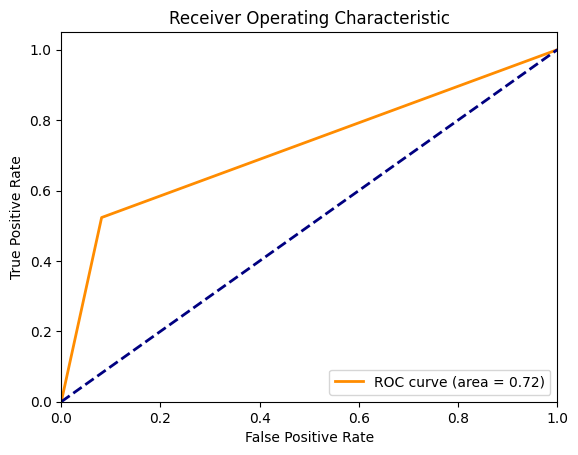

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Evaluations After Voting - Predictions Per Patient

<ipython-input-21-ed5075b6581e>:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
<ipython-input-21-ed5075b6581e>:9: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
<ipython-input-21-ed5075b6581e>:10: FutureWarning: The provided callable <function min at 0x7d5dc39fcdc0> is currently using SeriesGroupBy.min. In a

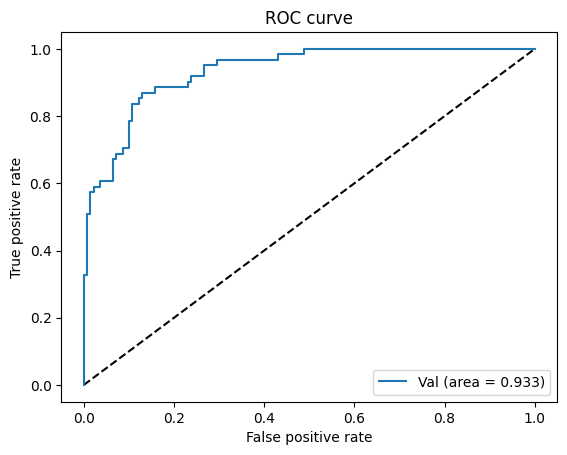

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def vote_score(df, score):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    # string = 'auroc_clinicalbert_'+readmission_mode+'.png'
    # plt.savefig(os.path.join(output_dir, string))

    return fpr, tpr, df_out

fpr, tpr, vote_df = vote_score(test, all_logits)

In [24]:
vote_df['predictions'] = (vote_df['logits'] > 0.5).astype(int)

# Calculate accuracy
accuracy = (vote_df['predictions'] == vote_df['ID']).mean()

print(f"Accuracy: {accuracy}")

Accuracy: 0.835
